# Dynamic Time Warping
References: 
1. https://rtavenar.github.io/blog/dtw.html?fbclid=IwAR0KXb0IF5DUXLIAMBE5Q2lTeGG7yigGyYULEhHvBhLfzXfdWBAmGogTpTg
2. https://ealizadeh.com/blog/introduction-to-dynamic-time-warping

## Import python modules

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import deepcopy, copy

## Generate data


In [2]:
def generate_dtw_data(xs,To=100):
    '''
    generate data for dtw using template of signals
    input:
        - xs <n x m, list of numpy array> : input signals where n denotes the number of signal and m denotes the number of repeatation
        - To <int> : time scale multiplication, the output signals are with the size of To*m
    output:
        - xs <n x m, list of numpy array> : generate signals where n denotes the number of signal and m denotes the number of repeatation 
    '''
    for n in range(len(xs)):
        for m in range(len(xs[n])):
            xs[n][m] = np.array(xs[n][m])
            t = np.linspace(0,1,To*xs[n][m].shape[0])
            xs[n][m] = np.interp(t,np.linspace(0,1,xs[n][m].shape[0]),xs[n][m])+np.random.normal(0,0.05,t.shape[0])
    return xs

# generate fake data
xs = [[],[]]
xs[0].append(np.array([0,0,0,1,2,3,4,5,4,3,2,1,0,0,1,2,1,0,0,0]))
xs[0].append(np.array([1,1,5,7,10,4,2,1,1,1,1,3,4,1,0,0,0]))
xs[0].append(np.array([-1,2,7,10,4,2,1,1,2,1,3,4,1,1,0,1,1]))

xs[1].append(np.array([0,0,0,-1,-1,-1,-2,-1,-2,-1,-1,0,0,0,2,2,5,2,0,0]))
xs[1].append(np.array([1,1,1,-2,-1,-1,-1,-1,-2,1,0,0,1,1,0,0,0]))
xs[1].append(np.array([-1,-1,-2,-1,-2,-3,-1,-2,1,0,0,1,2,0,0,0,0]))
xs = generate_dtw_data(xs,To=50)



plot the signals

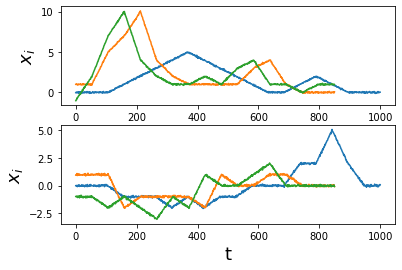

In [3]:
# visualize fake data
for n in range(len(xs)):
    plt.subplot(len(xs),1,n+1)
    for m in range(len(xs[n])):
        t = np.linspace(0,xs[n][m].shape,xs[n][m].shape[0])
        plt.plot(t,xs[n][m])
    plt.xlabel("t",fontsize=18)
    plt.ylabel("$x_i$",fontsize=18)
plt.show()

Here, we have two demonstration signals with different amplitude, different time scale, and different starting and ending points. We want to use the first (blue signal) as the template, and preprocess the second (orange signal).

## Signal Preprocessing

Note that there are four assumptions for dynamic time warping:
1. same starting and ending points
2. same amplitude/range
3. same time scale
4. same trend

Therefore, we have to preprocess them. First, we convert them into phase space, where the operation start at t = 0 and end at t = 1. Second, we  correct the offset in the starting and ending points. Third, we multiply the signal by the amplitude ratio between the template and the signal.  

In [4]:
def preprocess_dtw_input(xs,Td=1000,length_equalize=True,start_equalize=True,amplitude_equalize=True):
    '''
    generate data for dtw using template of signals
    input:
        - xs <n x m, list of numpy array> : input signals where n denotes the number of signal and m denotes the number of repeatation
        - Td <int> : desired time interval of the output signals
        - length_equalize <bool> : perform signal length equalization or not
        - start_equalize <bool> : perform starting and ending points equalization or not
        - amplitude_equalize <bool> : perform amplitude equalization or not   
    output:
        - xs <n x m, list of numpy array> : preprocessed signals where n denotes the number of signal and m denotes the number of repeatation 
    '''
    # equalize signal length
    if length_equalize:
        for n in range(len(xs)):
            for m in range(len(xs[n])):
                t = np.linspace(0,1,Td)
                xs[n][m] = np.interp(t,np.linspace(0,1,xs[n][m].shape[0]),xs[n][m])
        xs = np.array(xs)
    # equalize starting and ending points
    if start_equalize:
        start_avg = np.zeros(len(xs))
        end_avg = np.zeros(len(xs))
        for n in range(len(xs)):
            for m in range(len(xs[n])):
                start_avg[n] += xs[n][m][0]/len(xs)
                end_avg[n] += xs[n][m][-1]/len(xs)
        for n in range(len(xs)):
            for m in range(len(xs[n])):
                offset = np.linspace(xs[n][m][0]-start_avg[n],xs[n][m][-1]-end_avg[n],len(xs[n][0]))
                xs[n][m] = xs[n][m]-offset
    # equalize signal amplitude
    if amplitude_equalize:
        sigmax = np.zeros(len(xs))
        sigmin = np.zeros(len(xs))
        for n in range(len(xs)):
            for m in range(len(xs[n])):
                sigmax += np.max(xs[n][m])/len(xs)
                sigmin += np.min(xs[n][m])/len(xs)
        for n in range(len(xs)):
            for m in range(len(xs[n])):      
                posgain = sigmax[n]/np.max(xs[n][m])
                xs[n][m][xs[n][m]>0] = posgain*xs[n][m][xs[n][m]>0]
                neggain = sigmin[n]/np.min(xs[n][m])
                xs[n][m][(xs[n][m]<0)] = np.abs(neggain)*xs[n][m][(xs[n][m]<0)]
    return xs

xs = preprocess_dtw_input(xs,Td=1000)


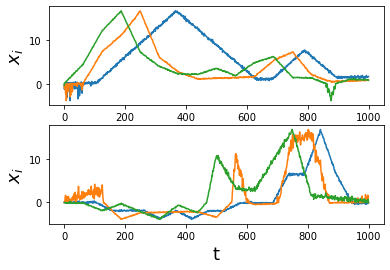

In [5]:
# visualize fake data
for n in range(len(xs)):
    plt.subplot(len(xs),1,n+1)
    for m in range(len(xs[n])):
        t = np.linspace(0,xs[n][m].shape,xs[n][m].shape[0])
        plt.plot(t,xs[n][m])
    plt.xlabel("t",fontsize=18)
    plt.ylabel("$x_i$",fontsize=18)
plt.show()

## Perform Dynamic Time Warping 
compute the distance function from the euclidian distance between each point ($x_i$ and $y_j$), return the distance matrix, and plot it.

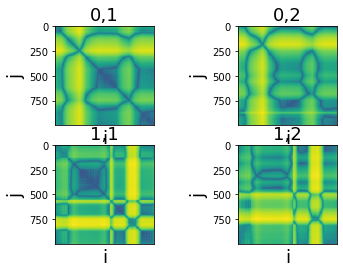

In [6]:
def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    input:
        - x <numpy array of length l> : template signal
        - y <numpy array of length l> : input signal (that we want to perform DTW)
    output:
        - dist <numpy array of size l x l> : distance matrix
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist


# visualize distance matrix
for n in range(len(xs)):
    for m in range(1,len(xs[n])):
        plt.subplot(len(xs),len(xs[0])-1,(len(xs[n])-1)*n+m)
        dist = compute_euclidean_distance_matrix(xs[n,1],xs[n,m])
        plt.imshow(dist**(1e-1))
        plt.xlabel("i",fontsize=18)
        plt.ylabel("j",fontsize=18)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        plt.title(str(n)+","+str(m),fontsize=18)
plt.show()

Then, compute accumulated cost/distance using dynamic programmin, and find the path with the shortest distance.

In [7]:
def compute_accumulated_cost_matrix(x, y, k= None) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    input:
        - x <numpy array of length l> : template signal
        - y <numpy array of length l> : input signal (that we want to perform DTW)
        - k <int> : local constrain
    output:
        - dist <numpy array of size l x l> : distance matrix
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
    if k is not None:
        idx = np.indices((len(y), len(x)))
        mask = np.zeros((len(y), len(x)))
        baseline = np.argmin(cost,0)#+[np.argmin(cost,0)[-1]]#idx[0,:,:]
        baseline =np.array([baseline]).transpose()
        mask[np.logical_or((baseline-k//2)>idx[1,:,:],(baseline+k//2)<idx[1,:,:])] += np.inf
        cost = mask.transpose()+cost
    return cost

def perform_dtw(xs,k=None):
    """Compute accumulated cost matrix for warp path using Euclidean distance on numpy array of all signals
    input:
        - xs <n x m, list of numpy array> : input signals where n denotes the number of signal and m denotes the number of repeatation
        - k <int> : local constrain
    output:
        - xs <n x m, list of numpy array> : output signals where n denotes the number of signal and m denotes the number of repeatation
    """
    xs_ = deepcopy(xs)
    R = []
    for n in range(len(xs)):
        temp = xs[n][0]
        R.append([])
        for m in range(1,len(xs[n])):
            r = compute_accumulated_cost_matrix(temp,xs[n][m],k=k)
            xs_[n][m] = xs[n,m,np.argmin(r,0)]
            R[-1].append(r)
    return xs_, R

xs, r = perform_dtw(xs,k=100)
r = np.array(r)

for each signal, plot the minimal cost path on the cumulative cost matrix using the red line.

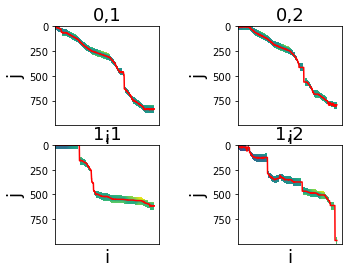

In [8]:
# visualize cummulate cost matrix
for n in range(len(xs)):
    for m in range(1,len(xs[n])):
        plt.subplot(len(xs),len(xs[0])-1,(len(xs[n])-1)*n+m)
        plt.plot(np.linspace(0,xs[n][m].shape[0],xs[n][m].shape[0]),np.argmin(r[n][m-1],0),c='red')
        plt.imshow(r[n][m-1]**(1e-1))
        plt.xlabel("i",fontsize=18)
        plt.ylabel("j",fontsize=18)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        plt.title(str(n)+","+str(m),fontsize=18)
plt.show()

Finally, plot the warped output signals

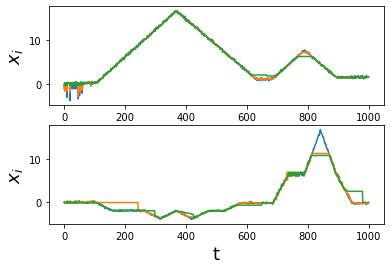

In [9]:
# visualize fake data
for n in range(len(xs)):
    plt.subplot(len(xs),1,n+1)
    for m in range(len(xs[n])):
        t = np.linspace(0,xs[n][m].shape,xs[n][m].shape[0])
        plt.plot(t,xs[n][m])
    plt.xlabel("t",fontsize=18)
    plt.ylabel("$x_i$",fontsize=18)
plt.show()